# ResNet Model

##### Step 1. Import modules and load dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
import torch.optim as optim


In [2]:
df = pd.read_csv('HSG Historical Data.csv',delimiter=",", thousands=',')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,21800.0,21700.0,21900.0,21450.0,6.02M,1.16%
1,05/30/2024,21550.0,21500.0,21800.0,21350.0,7.18M,-1.37%
2,05/29/2024,21850.0,22200.0,22400.0,21750.0,10.03M,-0.91%
3,05/28/2024,22050.0,22150.0,22150.0,21900.0,7.26M,0.23%
4,05/27/2024,22000.0,21500.0,22000.0,21400.0,6.74M,2.09%
...,...,...,...,...,...,...,...
1308,03/07/2019,6034.4,6237.7,6277.1,6034.4,9.73M,-3.87%
1309,03/06/2019,6277.1,6473.8,6559.1,6106.5,15.89M,-3.43%
1310,03/05/2019,6500.1,6559.1,6821.5,6401.7,16.02M,-0.40%
1311,03/04/2019,6526.3,6421.4,6526.3,6231.1,14.78M,6.99%


In [3]:
# Determine the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1313 non-null   object 
 1   Price     1313 non-null   float64
 2   Open      1313 non-null   float64
 3   High      1313 non-null   float64
 4   Low       1313 non-null   float64
 5   Vol.      1313 non-null   object 
 6   Change %  1313 non-null   object 
dtypes: float64(4), object(3)
memory usage: 71.9+ KB


##### Step 2. Selecting attribute

In [4]:
df = df[['Price']]
df = df.dropna()
df = df.reset_index(drop=True)
df

,Price
0,21800.0
1,21550.0
2,21850.0
3,22050.0
4,22000.0
...,...
1308,6034.4
1309,6277.1
1310,6500.1
1311,6526.3


In [5]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

##### Step 3. Split the dataset into train, test

In [6]:
# Calculate the number of samples for each set
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

# Split data into sets
train_data = df[:train_size]
test_data = df[train_size:]

# Check the size of each set
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1181
Test data size: 132


Step 4. Reshape input

In [7]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
train_last_windowsize = train_data[-time_step-1:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

In [9]:
X_train.shape

(1080, 100)

In [10]:
# Creating a Dataset for PyTorch for Use with a ResNet Model
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

##### Step 5. Process of training the model

In [11]:
# Define ResNet Model
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNet(Module):
    def __init__(self, c_in, c_out, nf=64, kss=[7, 5, 3]):
        super().__init__()
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.global_avg_pool(x).squeeze(-1)  # Global Average Pooling to (batch, channels)
        x = self.fc(x)
        return x

In [12]:
# Initialize model
model = ResNet(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/100, Loss: 0.00014219307922758162, Test Loss: 0.0009077892658145478
Epoch 2/100, Loss: 0.0005038135568611324, Test Loss: 0.0007517281143615643
Epoch 3/100, Loss: 0.02891652099788189, Test Loss: 0.025912859787543614
Epoch 4/100, Loss: 0.015804460272192955, Test Loss: 0.013119077309966087
Epoch 5/100, Loss: 0.00011763422662625089, Test Loss: 0.00012964504761233306
Epoch 6/100, Loss: 0.0030351083260029554, Test Loss: 0.002392395166680217
Epoch 7/100, Loss: 0.011380509473383427, Test Loss: 0.011300402383009592
Epoch 8/100, Loss: 6.944117194507271e-05, Test Loss: 0.0001064528405549936
Epoch 9/100, Loss: 2.7902187866857275e-05, Test Loss: 0.00023285368782429336
Epoch 10/100, Loss: 0.0004481293144635856, Test Loss: 0.0010614814042734604
Epoch 11/100, Loss: 9.668331767898053e-05, Test Loss: 5.641865027428139e-05
Epoch 12/100, Loss: 0.017295796424150467, Test Loss: 0.015108958507577578
Epoch 13/100, Loss: 0.0011164832394570112, Test Loss: 0.0007553161995019764
Epoch 14/100, Loss: 7.7269

In [14]:
# Predict on test data
model.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

##### Step 6. Evaluate the accuracy of test sets

In [15]:
# Actual values of the test set
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE
test_rmse = np.sqrt(np.mean((test_predict - y_test2)**2))
print('RMSE:', test_rmse)

# MAPE
mape_test = np.mean(np.abs((y_test2 -test_predict) / y_test2)) * 100
print('MAPE:', mape_test)

# MAE
mae_test = np.mean(np.abs(y_test2 - test_predict))
print("MAE:", mae_test)

RMSE: 1323.8083719728947
MAPE: 23.81991095756957
MAE: 1305.8316842743843


##### Step 7. Forecasting

In [16]:
# 30-day prediction
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output.extend(yhat.detach().numpy().tolist())

lst_output = scaler.inverse_transform(lst_output)

In [17]:
# 60-day prediction
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_60 = []

for i in range(60):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_60.extend(yhat.detach().numpy().tolist())

lst_output_60 = scaler.inverse_transform(lst_output_60)

In [18]:
# 90-day prediction
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

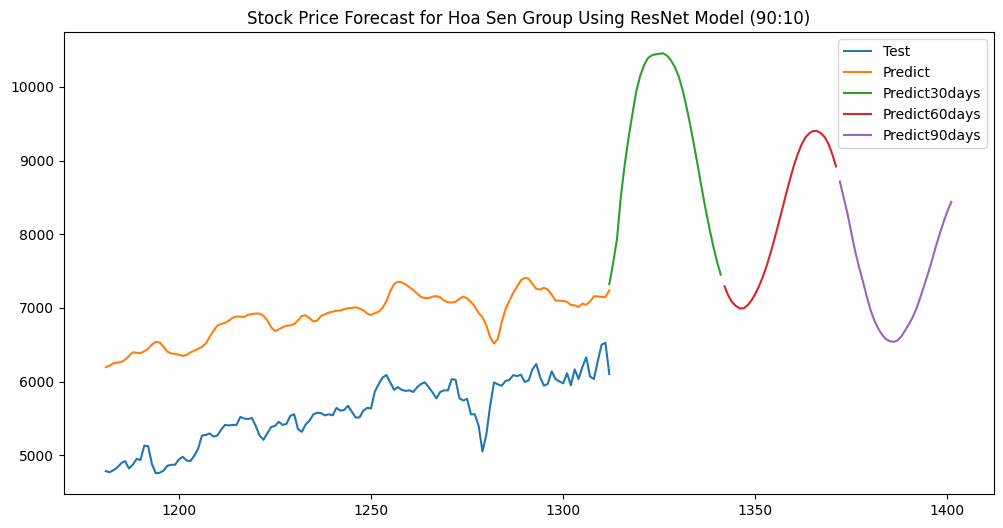

In [19]:
# Plot
plt.figure(figsize=(12, 6))
train_data_index = np.arange(0, train_size)

# Vẽ dữ liệu tập Test
test_data_index = np.arange(train_size, len(df))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Vẽ dữ liệu dự đoán cho tập kiểm tra (y_pred)
pred_data_index = np.arange(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(pred_data_index, test_predict, label='Predict')

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df) + 29, step=1)
plt.plot(predict_index_30, lst_output_90[:30], label='Predict30days')

# Vẽ dự đoán 60 ngày
predict_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df) + 59, step=1)
plt.plot(predict_index_60, lst_output_90[30:60], label='Predict60days')

# Vẽ dự đoán 90 ngày
predict_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df) + 89, step=1)
plt.plot(predict_index_90, lst_output_90[60:], label='Predict90days')

# Thêm chú thích và hiển thị đồ thị
plt.title('Stock Price Forecast for Hoa Sen Group Using ResNet Model (90:10)')
plt.legend(['Test', 'Predict', 'Predict30days', 'Predict60days', 'Predict90days'])
plt.show()


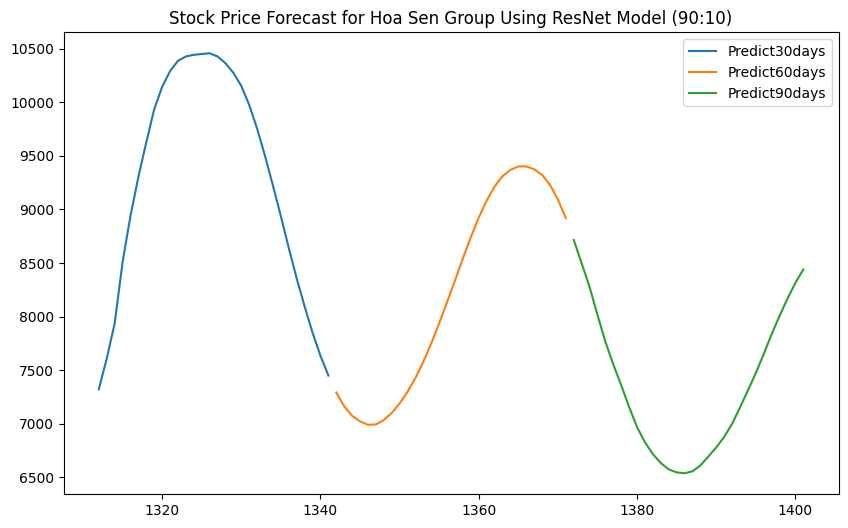

In [20]:
plt.figure(figsize=(10, 6))

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df) + 29, step=1)
plt.plot(predict_index_30, lst_output_90[:30], label='Predict30days')

# Vẽ dự đoán 60 ngày
predict_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df) + 59, step=1)
plt.plot(predict_index_60, lst_output_90[30:60], label='Predict60days')

# Vẽ dự đoán 90 ngày
predict_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df) + 89, step=1)
plt.plot(predict_index_90, lst_output_90[60:], label='Predict90days')

plt.title('Stock Price Forecast for Hoa Sen Group Using ResNet Model (90:10)')
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()

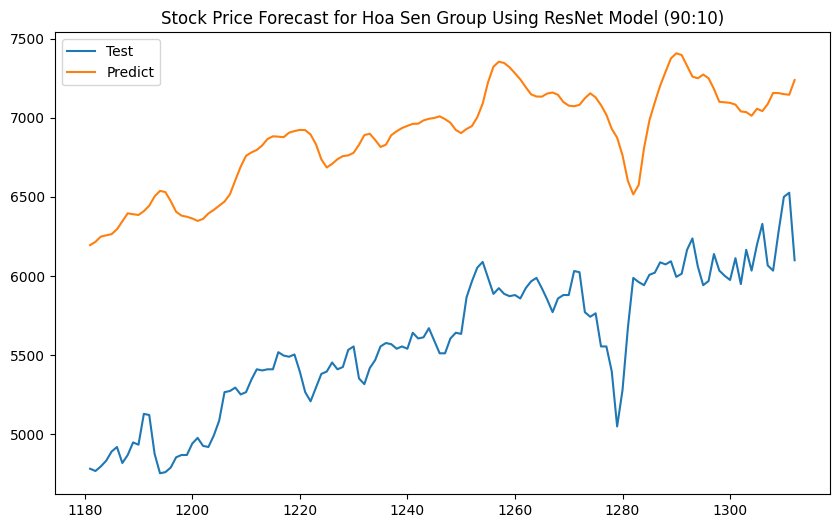

In [21]:
plt.figure(figsize=(10, 6))

# Vẽ dữ liệu tập Test
test_data_index = np.arange(train_size, len(df))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Vẽ dữ liệu dự đoán cho tập kiểm tra (y_pred)
pred_data_index = np.arange(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(pred_data_index, test_predict, label='Predict')

plt.title('Stock Price Forecast for Hoa Sen Group Using ResNet Model (90:10)')
plt.legend(['Test', 'Predict'])
plt.show()

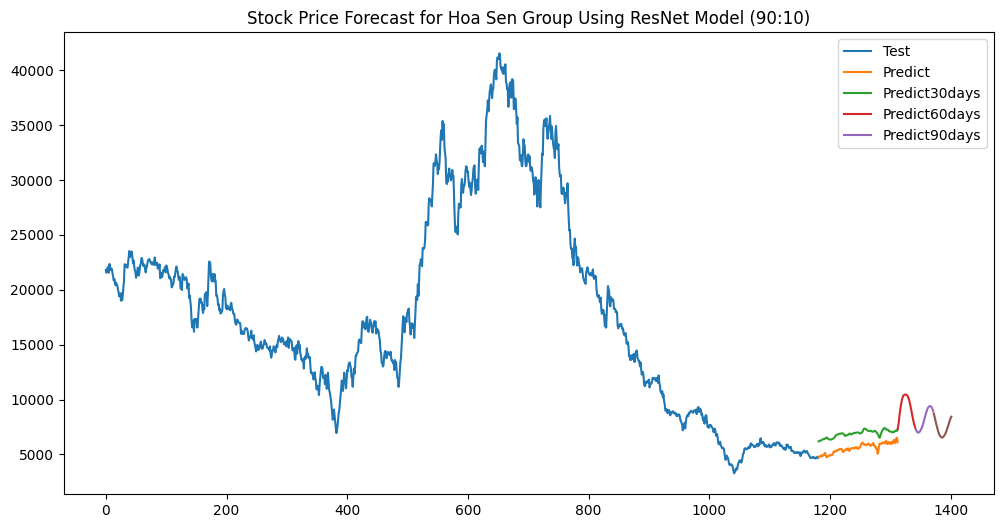

In [22]:
# Plot
plt.figure(figsize=(12, 6))

#Vẽ dữ liệu tập Train
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Vẽ dữ liệu tập Test
test_data_index = np.arange(train_size, len(df))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Vẽ dữ liệu dự đoán cho tập kiểm tra (y_pred)
pred_data_index = np.arange(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(pred_data_index, test_predict, label='Predict')

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df) + 29, step=1)
plt.plot(predict_index_30, lst_output_90[:30], label='Predict30days')

# Vẽ dự đoán 60 ngày
predict_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df) + 59, step=1)
plt.plot(predict_index_60, lst_output_90[30:60], label='Predict60days')

# Vẽ dự đoán 90 ngày
predict_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df) + 89, step=1)
plt.plot(predict_index_90, lst_output_90[60:], label='Predict90days')

# Thêm chú thích và hiển thị đồ thị
plt.title('Stock Price Forecast for Hoa Sen Group Using ResNet Model (90:10)')
plt.legend(['Test', 'Predict', 'Predict30days', 'Predict60days', 'Predict90days'])
plt.show()
